In [1]:
cd '/home/abhishekshar/hierarchichal_point_process/src'

/home/abhishekshar/hierarchichal_point_process/src


In [2]:
import os
import argparse
from argparse import Namespace

import numpy as np
import torch

import matplotlib.pyplot as plt

from utils.data_loader import get_dataloader
from utils.model_loader import ModelLoader
from main import setup_parser, _augment_params

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def plot_helper(intensity_x_vals, intensity_y_vals, data_vals):
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    
    ax[0].plot(intensity_x_vals, intensity_y_vals)
    ax[0].scatter(data_vals, [min(intensity_y_vals)]*len(data_vals), s=1)
    ax[0].set_xlim([0, 100])
    ax[0].set_title('Data till t=100')
    
    ax[1].plot(intensity_x_vals, intensity_y_vals)
    ax[1].scatter(data_vals, [min(intensity_y_vals)]*len(data_vals), s=1)
    ax[1].set_title('Full Data')

In [5]:
class BasePlotter():
    def __init__(self):
        self.timestamps = None

    def load_data(self, params:Namespace, split_name):
        split_name = "train" #TODO remove after testing
        #Data should reside in this path for all datasets. Ideally 5 cross fold validation.
        data_path = params.data_dir + params.data_name +'_'+str(params.cv_idx)+ f"_{split_name}.pkl"
        self.dataloader = get_dataloader(data_path, params.marker_type, params.batch_size)
        self.timestamps = [t_sequence[:,1] for t_sequence in self.dataloader.dataset.t_data]

class HawkesPlotter(BasePlotter):
    def __init__(self):
        super().__init__()
        
        self.params = {'lambda_0':.2, 'alpha':.8, 'beta':1.}

    def _get_intensity(self, t:float, hist:np.ndarray, params:dict):
        # params: [lambda0, alpha, beta]
        # hist must be numpy array
        hist = hist[(hist < t)]
        return params['lambda_0'] + params['alpha'] * np.sum(np.exp( -1.* (t - hist)/params['beta'] ))

    def plot_intensity(self, ax:plt.Axes, t_range:list=None):
        assert self.timestamps is not None
        data = self.timestamps[0]
        t_vals = np.arange(0, data[-1], .5)
        intensity_vals = [self._get_intensity(t=_t, hist=data, params=self.params) for _t in t_vals]
        
        ax.plot(t_vals, intensity_vals)
        ax.scatter(data, [min(intensity_vals)]*len(data), s=1)
        if t_range is not None:
            ax.set_xlim(t_range)
        ax.set_title('Data till t=100')
        
class RMTPPPlotter(BasePlotter):
    def __init__(self):
        super().__init__()
        
    def load_model(self, params:Namespace, model_state_path:str):
        loader = ModelLoader(params, model_state_path=model_state_path)
        self.model = loader.model
        self.model_path = loader.model_state_path
        
    def _get_hidden_states(self, x_data, t_data, mask):
        ## Copied from RMTPP._forward
        phi_x, phi_t = model.embed_x(x_data), model.embed_t(t_data)
        phi_xt = torch.cat([phi_x, phi_t], dim=-1) #(T,BS, emb_dim)
        time_intervals = t_data[:, :, 0:1] #(T, BS, 1)
        event_times = t_data[:, :, 1:2] #(T, BS, 1)
        T,BS,_ = phi_x.shape

        h_0 = torch.zeros(1, BS, model.rnn_hidden_dim).to(device)
        hidden_seq, _ = model.rnn(phi_xt, h_0)
        hidden_seq = torch.cat([h_0, hidden_seq], dim=0) #(T+1, BS, rnn_hidden_dim)
        return hidden_seq
        
    def _get_intensity(self, x_data, t_data, mask):
        
        device = torch.device('cuda')
        model = self.model.to(device)

        hidden_seq = self._get_hidden_states(x_data, t_data, mask)
        
        data_timestamps = t_data[:,:,1].cpu().numpy().flatten()
#         for t in np.arange(0, data_timestamps[-1], 0.5):
        log_intensity = model.marked_point_process_net.get_log_intensity(hidden_seq[:-1], time_intervals)
        return log_intensity.exp().detach().cpu().numpy().flatten()
    
    def plot_intensity(self, ax:plt.Axes, t_range:list=None):
        assert self.timestamps is not None
        idx = 1
        data = self.timestamps[idx]
#         t_vals = np.arange(0, data[-1], .5)
#         intensity_vals = [self._get_intensity(t=_t, hist=data, params=self.params) for _t in t_vals]
        
#         ax.plot(t_vals, intensity_vals)

        x_data, t_data, mask = self.dataloader.collate_fn([self.dataloader.dataset[i] for i in range(idx)])
        intensity_vals = self._get_intensity(x_data, t_data, mask)
        timestamps = t_data[:,:,1].cpu().numpy().flatten()
        ax.plot(timestamps, intensity_vals)
    
#         ax.scatter(data, [min(intensity_vals)]*len(data), s=1)
        if t_range is not None:
            ax.set_xlim(t_range)
        ax.set_title('Data till t=100')

NameError: name 'model' is not defined

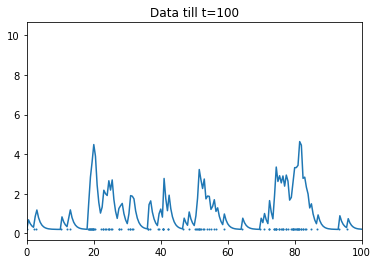

In [6]:
parser = setup_parser()
params = parser.parse_args(args=[])
###
params.model = 'rmtpp'
params.data_name = 'simulated_hawkes'
###
_augment_params(params)

## True Model
hawkes_plotter = HawkesPlotter()
# Load data
hawkes_plotter.load_data(params, "train")

## RMTPP
rmtpp_plotter = RMTPPPlotter()
# Load data
rmtpp_plotter.load_data(params, "train")
# Load model object & Load model state
model_state_path = os.path.join('model', params.data_name, params.model, "_g1_do0.5_b32_h256_l20.0_l20_gn10.0_lr0.001_c10_s1_tlintensity_ai40")
rmtpp_plotter.load_model(params, model_state_path)

# Plot
fig, ax = plt.subplots(1,1)
hawkes_plotter.plot_intensity(ax, t_range=[0, 100])
rmtpp_plotter.plot_intensity(ax, t_range=[0,100])

In [55]:
def run_fwd(model, x_data, t_data, mask):
    device = torch.device('cuda')
    model = model.to(device)
    ## Copied from RMTPP._forward
    phi_x, phi_t = model.embed_x(x_data), model.embed_t(t_data)
    phi_xt = torch.cat([phi_x, phi_t], dim=-1) #(T,BS, emb_dim)
    time_intervals = t_data[:, :, 0:1] #(T, BS, 1)
    event_times = t_data[:, :, 1:2] #(T, BS, 1)
    T,BS,_ = phi_x.shape
    
    h_0 = torch.zeros(1, BS, model.rnn_hidden_dim).to(device)
    hidden_seq, _ = model.rnn(phi_xt, h_0)
    hidden_seq = torch.cat([h_0, hidden_seq], dim=0) #(T+1, BS, rnn_hidden_dim)
    
    log_intensity = model.marked_point_process_net.get_log_intensity(hidden_seq[:-1], time_intervals)
    return log_intensity.exp().detach().cpu().numpy().flatten()

In [57]:
run_fwd(rmtpp_plotter.model, *rmtpp_plotter.dataloader.collate_fn([rmtpp_plotter.dataloader.dataset[i] for i in range(1)]))

array([0.9988958 , 0.73644817, 1.2227725 , ..., 0.9754696 , 1.078384  ,
       1.0210043 ], dtype=float32)

In [62]:
%pdb

Automatic pdb calling has been turned ON


In [17]:
rmtpp_plotter.dataloader.dataset[0]

(array([1, 1, 1, ..., 1, 1, 1]), array([[0.00000000e+00, 0.00000000e+00],
        [2.18347034e+00, 2.18347034e+00],
        [5.08512582e-01, 2.69198292e+00],
        ...,
        [3.97190183e+00, 1.31533601e+03],
        [1.07414355e+00, 1.31641015e+03],
        [2.65405615e+00, 1.31906421e+03]]))

In [29]:
rmtpp_plotter.dataloader.collate_fn([rmtpp_plotter.dataloader.dataset[i] for i in range(3)])

(tensor([[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         ...,
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]], device='cuda:0'), tensor([[[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],
 
         [[2.1835e+00, 2.1835e+00],
          [6.3766e-02, 6.3766e-02],
          [1.7809e+00, 1.7809e+00]],
 
         [[5.0851e-01, 2.6920e+00],
          [1.4160e-01, 2.0537e-01],
          [7.0218e-01, 2.4831e+00]],
 
         ...,
 
         [[3.9719e+00, 1.3153e+03],
          [3.1062e-01, 1.4565e+03],
          [9.6077e-01, 1.4455e+03]],
 
         [[1.0741e+00, 1.3164e+03],
          [2.9983e+00, 1.4595e+03],
          [5.6027e-01, 1.4461e+03]],
 
         [[2.6541e+00, 1.3191e+03],
          [2.7537e-01, 1.4597e+03],
          [6.4350e-01, 1.4467e+03]]], device='cuda:0'), tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]